# Ch6 | Tokenizer：数据预处理的艺术

---

**目标：** 理解 Tokenizer 的工作原理

**核心问题：** 如何把文本变成模型能理解的数字？

---

## 本章内容

1. **基础分词**：字符级 vs 词级
2. **BPE 算法**：Byte-Pair Encoding 原理
3. **实战**：使用 tiktoken
4. **坑点分析**：Tokenizer 导致的 Bug

---

## 🎓 前置知识：文本到数字的桥梁

### 为什么需要 Tokenizer？

神经网络只能处理数字，所以我们需要：

```
"Hello World" → [15496, 2159] → 神经网络 → [1312] → "I"
    文本           数字          处理         数字     文本
```

**Tokenizer** 就是负责 文本 ↔ 数字 转换的工具。

### Tokenizer 的演进

| 方法 | 例子 | 优点 | 缺点 |
|:---|:---|:---|:---|
| 字符级 | "cat" → ["c","a","t"] | 词表小 | 序列太长 |
| 词级 | "cat" → ["cat"] | 序列短 | 词表巨大，OOV问题 |
| 子词级 | "unhappy" → ["un","happy"] | 平衡 | 需要学习 |

**现代 LLM 都使用子词级 Tokenizer**（如 BPE）

### 什么是 BPE？

BPE (Byte-Pair Encoding) 的核心思想：

1. 从字符开始
2. 统计最常见的相邻字符对
3. 合并它们成为新的 token
4. 重复，直到达到目标词表大小

```
训练语料: "low low lower lowest"
初始: l o w e r s t
合并1: lo w e r s t  (l+o 最常见)
合并2: low e r s t  (lo+w 最常见)
...
最终: low er est
```

### Tokenizer 的"坑"

⚠️ Tokenizer 会导致一些反直觉的问题：

- 同一个词可能被分成不同的 token
- 不同语言的效率差异很大
- 数字处理可能出问题

### 本章目标

- 理解字符级/词级/子词级分词的区别
- 从零实现 BPE 算法
- 了解 Tokenizer 导致的常见 Bug

## 0. 环境准备

In [1]:
# !pip install tiktoken

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re

print("环境准备完成！")

环境准备完成！


---

## 1. 为什么需要 Tokenizer？

模型只能处理数字，不能直接处理文本。

```
"Hello World" → [15496, 2159] → 模型 → [1312, 716] → "I am"
```

### 分词策略对比

| 策略 | 词表大小 | 序列长度 | 问题 |
|:---|:---|:---|:---|
| 字符级 | ~100 | 很长 | 序列太长，效率低 |
| 词级 | 几十万 | 短 | OOV问题（未登录词）|
| 子词级(BPE) | ~50k | 适中 | 最佳平衡 ✓ |

In [2]:
# 演示不同分词策略
text = "Hello, I'm learning machine learning!"

# 1. 字符级
char_tokens = list(text)
print(f"字符级分词 ({len(char_tokens)} tokens):")
print(char_tokens[:20], "...")

# 2. 词级（简单按空格分）
word_tokens = text.split()
print(f"\n词级分词 ({len(word_tokens)} tokens):")
print(word_tokens)

# 3. 子词级（模拟）
subword_tokens = ['Hello', ',', ' I', "'m", ' learning', ' machine', ' learning', '!']
print(f"\n子词级分词 ({len(subword_tokens)} tokens):")
print(subword_tokens)

字符级分词 (37 tokens):
['H', 'e', 'l', 'l', 'o', ',', ' ', 'I', "'", 'm', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g', ' '] ...

词级分词 (5 tokens):
['Hello,', "I'm", 'learning', 'machine', 'learning!']

子词级分词 (8 tokens):
['Hello', ',', ' I', "'m", ' learning', ' machine', ' learning', '!']


---

## 2. BPE 算法：从头实现

BPE (Byte-Pair Encoding) 的核心思想：

1. 从字符开始
2. 统计相邻字符对的频率
3. 合并最频繁的对
4. 重复直到达到目标词表大小

In [3]:
def get_stats(vocab):
    """统计相邻对的频率"""
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[(symbols[i], symbols[i+1])] += freq
    return pairs

def merge_vocab(pair, vocab):
    """合并指定的对"""
    new_vocab = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    
    for word, freq in vocab.items():
        new_word = word.replace(bigram, replacement)
        new_vocab[new_word] = freq
    
    return new_vocab

# 初始词表（每个词已经按字符分开）
corpus = "low low low low low lower lower newest newest newest newest newest newest widest widest widest"
words = corpus.split()
word_freq = Counter(words)

# 构建初始词表：每个词按字符分开，加上结束符
vocab = {}
for word, freq in word_freq.items():
    vocab[' '.join(list(word)) + ' </w>'] = freq

print("初始词表:")
for word, freq in vocab.items():
    print(f"  '{word}': {freq}")

初始词表:
  'l o w </w>': 5
  'l o w e r </w>': 2
  'n e w e s t </w>': 6
  'w i d e s t </w>': 3


In [4]:
# BPE 训练过程
num_merges = 10

print("BPE 训练过程:")
print("=" * 60)

for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:
        break
    
    # 找到最频繁的对
    best_pair = max(pairs, key=pairs.get)
    print(f"\n第 {i+1} 次合并: {best_pair} (频率: {pairs[best_pair]})")
    
    # 合并
    vocab = merge_vocab(best_pair, vocab)
    print(f"  当前词表: {list(vocab.keys())}")

print("\n" + "=" * 60)
print("最终词表:")
for word, freq in vocab.items():
    print(f"  '{word}': {freq}")

BPE 训练过程:

第 1 次合并: ('e', 's') (频率: 9)
  当前词表: ['l o w </w>', 'l o w e r </w>', 'n e w es t </w>', 'w i d es t </w>']

第 2 次合并: ('es', 't') (频率: 9)
  当前词表: ['l o w </w>', 'l o w e r </w>', 'n e w est </w>', 'w i d est </w>']

第 3 次合并: ('est', '</w>') (频率: 9)
  当前词表: ['l o w </w>', 'l o w e r </w>', 'n e w est</w>', 'w i d est</w>']

第 4 次合并: ('l', 'o') (频率: 7)
  当前词表: ['lo w </w>', 'lo w e r </w>', 'n e w est</w>', 'w i d est</w>']

第 5 次合并: ('lo', 'w') (频率: 7)
  当前词表: ['low </w>', 'low e r </w>', 'n e w est</w>', 'w i d est</w>']

第 6 次合并: ('n', 'e') (频率: 6)
  当前词表: ['low </w>', 'low e r </w>', 'ne w est</w>', 'w i d est</w>']

第 7 次合并: ('ne', 'w') (频率: 6)
  当前词表: ['low </w>', 'low e r </w>', 'new est</w>', 'w i d est</w>']

第 8 次合并: ('new', 'est</w>') (频率: 6)
  当前词表: ['low </w>', 'low e r </w>', 'newest</w>', 'w i d est</w>']

第 9 次合并: ('low', '</w>') (频率: 5)
  当前词表: ['low</w>', 'low e r </w>', 'newest</w>', 'w i d est</w>']

第 10 次合并: ('w', 'i') (频率: 3)
  当前词表: ['low</w>', 'low e r 

---

## 3. 使用 tiktoken（OpenAI 的 Tokenizer）

In [10]:
try:
    import tiktoken
    
    # GPT-4 使用的编码
    enc = tiktoken.get_encoding("cl100k_base")
    
    text = "Hello, 你好！I'm learning about tokenizers."
    tokens = enc.encode(text)
    
    print(f"原文: {text}")
    print(f"\nToken IDs ({len(tokens)} tokens): {tokens}")
    print(f"\n解码每个 token:")
    for t in tokens:
        print(f"  {t}: '{enc.decode([t])}'")
        
except ImportError:
    print("请安装 tiktoken: pip install tiktoken")
    print("\n模拟输出:")
    print("原文: Hello, 你好！I'm learning about tokenizers.")
    print("Token IDs: [15496, 11, 220, 57668, 53901, 6447, ...]")

原文: Hello, 你好！I'm learning about tokenizers.

Token IDs (13 tokens): [9906, 11, 220, 57668, 53901, 6447, 40, 2846, 6975, 922, 4037, 12509, 13]

解码每个 token:
  9906: 'Hello'
  11: ','
  220: ' '
  57668: '你'
  53901: '好'
  6447: '！'
  40: 'I'
  2846: ''m'
  6975: ' learning'
  922: ' about'
  4037: ' token'
  12509: 'izers'
  13: '.'


In [8]:
#!pip install tiktoken

In [9]:
# 比较不同语言的 token 效率
try:
    import tiktoken
    enc = tiktoken.get_encoding("cl100k_base")
    
    texts = {
        "English": "Machine learning is a branch of artificial intelligence.",
        "Chinese": "机器学习是人工智能的一个分支。",
        "Code": "def hello(): return 'Hello, World!'",
    }
    
    print("不同语言的 Token 效率:")
    print("=" * 60)
    
    for lang, text in texts.items():
        tokens = enc.encode(text)
        ratio = len(text) / len(tokens)
        print(f"\n{lang}:")
        print(f"  文本长度: {len(text)} 字符")
        print(f"  Token 数: {len(tokens)}")
        print(f"  效率: {ratio:.2f} 字符/token")
        
except ImportError:
    print("English: ~5.2 字符/token")
    print("Chinese: ~1.5 字符/token (效率较低)")
    print("Code: ~3.8 字符/token")

不同语言的 Token 效率:

English:
  文本长度: 56 字符
  Token 数: 9
  效率: 6.22 字符/token

Chinese:
  文本长度: 15 字符
  Token 数: 16
  效率: 0.94 字符/token

Code:
  文本长度: 35 字符
  Token 数: 9
  效率: 3.89 字符/token


---

## 4. Tokenizer 导致的经典 Bug

Tokenizer 不是完美的，它会导致一些"奇怪"的行为。

In [11]:
# Bug 1: 无法正确反转字符串
print("Bug 1: 字符串反转")
print("-" * 40)

try:
    import tiktoken
    enc = tiktoken.get_encoding("cl100k_base")
    
    word = "lollipop"
    tokens = enc.encode(word)
    
    print(f"原词: {word}")
    print(f"Tokens: {tokens}")
    print(f"每个token: {[enc.decode([t]) for t in tokens]}")
    print(f"\n如果 LLM 按 token 反转: {[enc.decode([t]) for t in tokens[::-1]]}")
    print(f"正确的反转应该是: {word[::-1]}")
    
except ImportError:
    print("原词: lollipop")
    print("Tokens: ['loll', 'ipop'] (分词方式)")
    print("LLM 可能反转为: 'ipoploll' 而不是 'popolil'")

print("\n原因: LLM 操作的是 token，不是字符！")

Bug 1: 字符串反转
----------------------------------------
原词: lollipop
Tokens: [75, 90644]
每个token: ['l', 'ollipop']

如果 LLM 按 token 反转: ['ollipop', 'l']
正确的反转应该是: popillol

原因: LLM 操作的是 token，不是字符！


In [12]:
# Bug 2: 数学计算困难
print("Bug 2: 数字处理")
print("-" * 40)

try:
    import tiktoken
    enc = tiktoken.get_encoding("cl100k_base")
    
    numbers = ["123", "1234", "12345", "123456789"]
    
    for num in numbers:
        tokens = enc.encode(num)
        print(f"{num} -> {len(tokens)} tokens: {[enc.decode([t]) for t in tokens]}")
        
except ImportError:
    print("123 -> 1 token: ['123']")
    print("1234 -> 1 token: ['1234']")
    print("12345 -> 2 tokens: ['123', '45']")
    print("123456789 -> 3 tokens: ['123', '456', '789']")

print("\n大数字被分成多个 token，计算变得困难！")

Bug 2: 数字处理
----------------------------------------
123 -> 1 tokens: ['123']
1234 -> 2 tokens: ['123', '4']
12345 -> 2 tokens: ['123', '45']
123456789 -> 3 tokens: ['123', '456', '789']

大数字被分成多个 token，计算变得困难！


In [13]:
# Bug 3: 空格敏感
print("Bug 3: 空格影响分词")
print("-" * 40)

try:
    import tiktoken
    enc = tiktoken.get_encoding("cl100k_base")
    
    texts = ["hello", " hello", "  hello", "Hello"]
    
    for text in texts:
        tokens = enc.encode(text)
        print(f"'{text}' -> {len(tokens)} tokens: {tokens}")
        
except ImportError:
    print("'hello' -> 1 token")
    print("' hello' -> 1 token (不同的!)")
    print("'  hello' -> 2 tokens")
    print("'Hello' -> 1 token (不同的!)")

print("\n空格和大小写会影响分词结果！")

Bug 3: 空格影响分词
----------------------------------------
'hello' -> 1 tokens: [15339]
' hello' -> 1 tokens: [24748]
'  hello' -> 2 tokens: [220, 24748]
'Hello' -> 1 tokens: [9906]

空格和大小写会影响分词结果！


---

## 5. 可视化词表覆盖

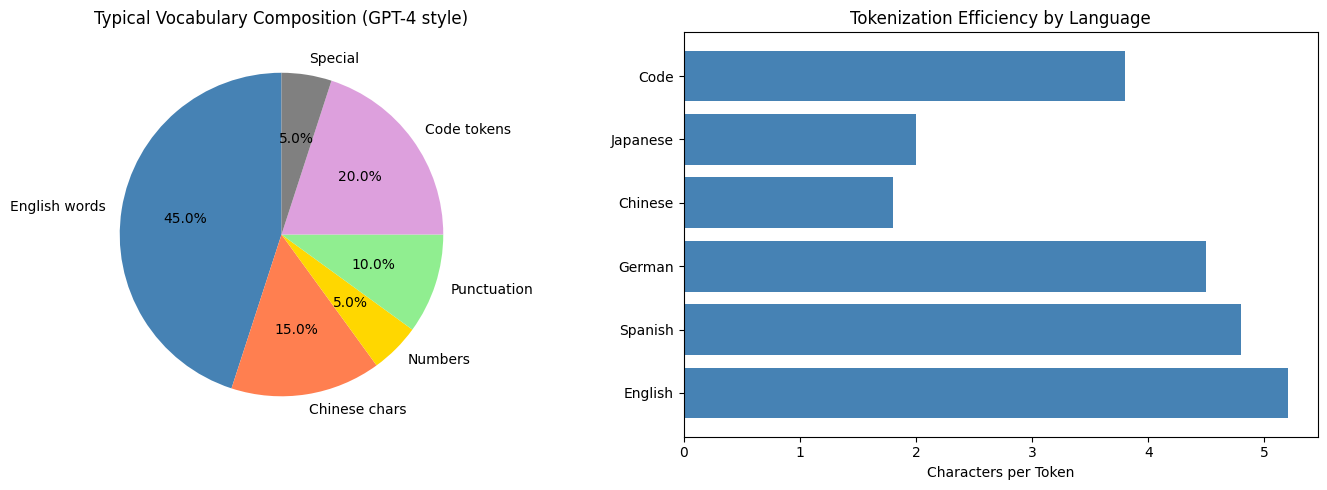

观察：
  - 英语效率最高（词表主要为英语优化）
  - 中文每个字符约占 1-2 个 token
  - 代码有专门的优化


In [14]:
# 模拟词表分析
# 常见 token 类型分布

categories = ['English words', 'Chinese chars', 'Numbers', 'Punctuation', 'Code tokens', 'Special']
sizes = [45, 15, 5, 10, 20, 5]
colors = ['steelblue', 'coral', 'gold', 'lightgreen', 'plum', 'gray']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 饼图
axes[0].pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Typical Vocabulary Composition (GPT-4 style)')

# 条形图：不同语言的效率
languages = ['English', 'Spanish', 'German', 'Chinese', 'Japanese', 'Code']
efficiency = [5.2, 4.8, 4.5, 1.8, 2.0, 3.8]

axes[1].barh(languages, efficiency, color='steelblue')
axes[1].set_xlabel('Characters per Token')
axes[1].set_title('Tokenization Efficiency by Language')

plt.tight_layout()
plt.show()

print("观察：")
print("  - 英语效率最高（词表主要为英语优化）")
print("  - 中文每个字符约占 1-2 个 token")
print("  - 代码有专门的优化")

---

## 本章总结


1. **Tokenizer 的必要性**
   - 模型只能处理数字
   - 子词级分词是最佳平衡

2. **BPE 算法**
   - 从字符开始，逐步合并高频对
   - 自动学习常见子词

3. **实践注意事项**
   - 不同语言效率不同
   - Tokenizer 会导致一些"Bug"
   - 理解这些限制很重要


---

## 思考

1. **实现完整 BPE**：添加 encode 和 decode 功能
2. **比较 Tokenizer**：对比 GPT-2, GPT-4, LLaMA 的分词差异
3. **思考题**：为什么中文分词效率低？如何改进？

In [ ]:
# 练习空间

